In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii
from pathlib import Path
import yt
import sys
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from mpl_toolkits.axes_grid1 import AxesGrid
import pickle
import os
import re
from mpl_toolkits.axes_grid1 import ImageGrid,Grid
from matplotlib import gridspec
from scipy.optimize import curve_fit
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [73]:
def solver(a,b,f,err,y):
    x0,x1=a,b
    while np.abs(x1-x0)>err:
        x2=(x1-x0)*(y-f(x0))/(f(x1)-f(x0))+x0
        x0=x1
        x1=x2
    return x1
def Q(M):
    xi=np.log10(M)
    return M*10**(46.7*xi**7/(7.28+xi**7))
def integrate(dt,dvdt):
    dv=dt*dvdt
    return np.array([np.sum(dv[:l]) for l in range(len(dt))])
def t_find(model):
    s = pa.LoadSim(str(model))
    h = pa.read_hst(s.files['hst'])
    Mneu = h['mass_neu']/h['mass_neu'][0]
    result = [s.par['problem']['t0_src']]
    for perc in [0.75,0.5,0.1]:
        t = np.min(h['time'][Mneu<=perc])
        result.append(t)        
    tarr=np.array([])
    for num in s.nums:
        ds = s.load_hdf5(num,load_method='yt')
        t = ds.current_time
        tarr=np.hstack([tarr,t])
    t_ind=[]
    for  tt in result:
        if tt>=0:
            t_ind.append(np.where(tarr==np.min(tarr[tarr>=tt]))[0][0])
        else:
            t_ind.append(np.nan)
    return t_ind
def projectionplot(field,ax_num):
    return np.sum(field,axis=ax_num)
def title_(model):
    s=pa.LoadSim(model)
    inp=s.par['problem']
    title='nH0{:}'.format(np.log10(inp['nH0']))+',Qi{:}'.format(np.log10(inp['Qi']))+',vesc{:.2f}'.format(inp['vesc0']/ci)
    return title
def load_rr(model,num):
    datapath=Path(str(model)+'/evap_dictionary')
    dict_list=list(datapath.glob('t=*'))
    dict_list.sort()
    with open(dict_list[num], 'rb') as fr:
        rr = pickle.load(fr)
    return rr
def load_hd(model):
    ph=str(model)+'/evap_dictionary/for_scaling'
    with open(ph, 'rb') as fr:
        scale = pickle.load(fr)
    history={}
    for key in scale[0].keys():
        if len([scale[0][key]])==1:
            try:
                history[key]=np.array([rr[key] for rr in scale])
            except:
                history[key]=np.array([rr[key].value for rr in scale])
    return history
def Sig_Em_2D(nums,model):
    s=pa.LoadSim(model)
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[0.8,0.03]))
    norm = plt.Normalize(0, 0.8*s.par['time']['tlim'])
    cmap = mpl.cm.plasma
    for num in nums:
        ds=s.load_hdf5(num,load_method='yt')
        add_fields(ds,s)
        ad=ds.all_data()
        ad_grid = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
        dz=ad_grid['dz']
        R=np.sqrt(ad_grid['x'][:,:,0]**2+ad_grid['y'][:,:,0]**2)
        Sig=projectionplot(ad_grid['rho']*dz*s.u.mass.value,2)
        Em=projectionplot(ad_grid['ne^2']*dz/s.par['units']['length_cgs']**6,2)
        dA=ad_grid['dx'][:,:,0]*ad_grid['dy'][:,:,0]
        
        m,n=np.shape(R)
        R1d=np.reshape(R,[1,m*n])[0]
        Sig1d=np.reshape(Sig,[1,m*n])[0]
        Em1d=np.reshape(Em,[1,m*n])[0]
        dA1d=np.reshape(dA,[1,m*n])[0]
        x,y=np.histogram(R1d,bins=np.linspace(0,np.max(R1d),50),weights=Sig1d*dA1d)
        x=np.array([np.sum(x[:k]) for k in range(len(x))])
        x2,y2=np.histogram(R1d,bins=np.linspace(0,np.max(R1d),50),weights=Em1d*dA1d)
        x2=np.array([np.sum(x2[:k]) for k in range(len(x2))])
        if num==nums[0]:
            axes[0].plot(0.5*(y[:-1]+y[1:]),x/x[-1],'-',c=cmap(norm(ds.current_time.to('Myr'))),label='$\int_{0}^{R}\Sigma(r) 2\pi rdr$ in 2d')
            axes[0].plot(0.5*(y2[:-1]+y2[1:]),x2/x2[-1],'--',c=cmap(norm(ds.current_time.to('Myr'))),label='$\int_{0}^{R}Em(r) 2\pi rdr$ in 2d')
        else:
            axes[0].plot(0.5*(y[:-1]+y[1:]),x/x[-1],'-',c=cmap(norm(ds.current_time.to('Myr'))))
            axes[0].plot(0.5*(y2[:-1]+y2[1:]),x2/x2[-1],'--',c=cmap(norm(ds.current_time.to('Myr'))))
        
    axes[0].set_xlabel('radius')
    axes[0].set_ylabel('normalized Mass & emission', size=20)
    axes[0].legend(loc='lower right')
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, cax=axes[-1], label='time [Myr]')
    axes[0].set_title(title(model))

<>:87: SyntaxWarning: invalid escape sequence '\i'
<>:88: SyntaxWarning: invalid escape sequence '\i'
<>:87: SyntaxWarning: invalid escape sequence '\i'
<>:88: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_568880/3537982148.py:87: SyntaxWarning: invalid escape sequence '\i'
  axes[0].plot(0.5*(y[:-1]+y[1:]),x/x[-1],'-',c=cmap(norm(ds.current_time.to('Myr'))),label='$\int_{0}^{R}\Sigma(r) 2\pi rdr$ in 2d')
/tmp/ipykernel_568880/3537982148.py:88: SyntaxWarning: invalid escape sequence '\i'
  axes[0].plot(0.5*(y2[:-1]+y2[1:]),x2/x2[-1],'--',c=cmap(norm(ds.current_time.to('Myr'))),label='$\int_{0}^{R}Em(r) 2\pi rdr$ in 2d')


In [6]:
path='/gpfs/ckswls1699/grammar/Nx128'
datapath=Path(path)
test=list(datapath.glob('*Q49.0n2.0*'))
test

[PosixPath('/gpfs/ckswls1699/grammar/Nx128/hii_Q49.0n2.0M5')]

In [38]:
s=pa.LoadSim(str(test[0]))
h=pa.read_hst(s.files['hst'])
ds=s.load_hdf5(50,load_method='yt')
tt=ds.current_time
tind=np.where(h['time']>=tt)[0][0]
add_fields(ds,s)
ad=ds.all_data()

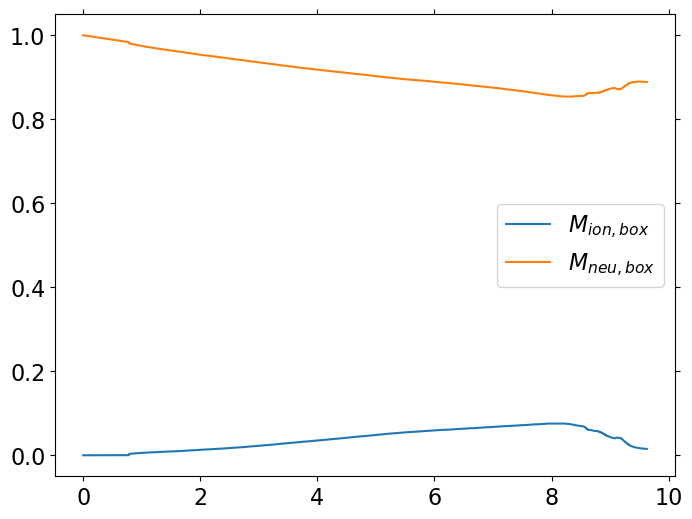

In [17]:
plt.plot(h['time'],h['mass_ion']/h['mass'][0],label='$M_{ion,box}$')
plt.plot(h['time'],h['mass_neu']/h['mass'][0],label='$M_{neu,box}$')
plt.legend()

In [74]:
ti=np.array(h['time'])
dt=ti[1:]-ti[:-1]
mi_out=np.array(h['dot_mass_out_ion'])
mn_out=np.array(h['dot_mass_out_neu'])
Mi_out=integrate(dt,mi_out[:-1])
Mn_out=integrate(dt,mn_out[:-1])
pi_out=np.array(h['dot_pr_out_ion'])
pn_out=np.array(h['dot_pr_out_neu'])
Pi_out=integrate(dt,pi_out[:-1])
Pn_out=integrate(dt,pn_out[:-1])

Text(0, 0.5, '$v_{out}=P_{r,out}/M_{out}$')

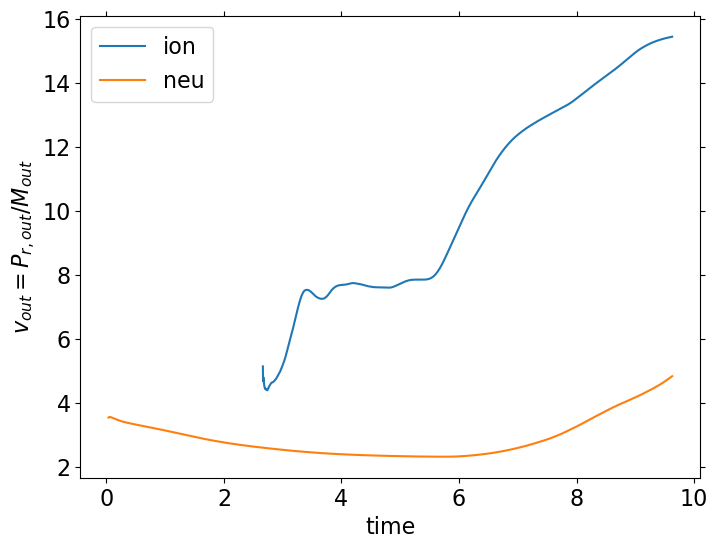

In [78]:
plt.plot(ti[:-1],Pi_out/Mi_out,label='ion')
plt.plot(ti[:-1],Pn_out/Mn_out,label='neu')
plt.legend()
plt.xlabel('time')
plt.ylabel('$v_{out}=P_{r,out}/M_{out}$')

In [11]:
h.keys()

Index(['time', 'dt', 'mass', '1mom', '2mom', '3mom', '1KE', '2KE', '3KE',
       'totE', '0scalar', 'mass_star', 'Ltot0', 'Lesc0', 'Ldust0', 'IF_num',
       'IF_num_r', 'IF_vol', 'IF_vol_r', 'sh_vol', 'sh_vol_r', 'sh_mass',
       'sh_mass_r', 'sh_mass_vr', 'sh_e_kin', 'mass_neu', 'mass_ion',
       'dot_mass_out_ion', 'dot_mass_out_neu', 'dot_mass_ion', 'pr_ion',
       'pr_neu', 'dot_pr_out_ion', 'dot_pr_out_neu', 'dot_pr_ion',
       'force_thm_neu', 'force_thm_ion', 'force_cent_neu', 'force_cent_ion',
       'force_grav_neu', 'force_grav_ion', 'int_sqr_n_ion_dv', 'vol_ion',
       'qi_eff'],
      dtype='object')

In [80]:
print('v3d at t0',s.par['problem']['v3d'],np.sqrt(2*h['totE']/h['mass'])[0],'\n')
print('time',h['time'][tind],tt,'\n')
dM=ad['cell_volume']*ad['rho']
xhi=ad['r0']
print('mass_neu',h['mass_neu'][tind],np.sum(dM[xhi>=0.5]))
print('mass_ion',h['mass_ion'][tind],np.sum(dM[xhi<0.5]))
print('dot_mass_ion',h['dot_mass_ion'][tind-1],np.sum(-ad['rho_hi_dot']*ad['cell_volume']),'\n')

xe=np.max(ad['x'])
Mi_out,Mn_out=0.0,0.0
Pi_out,Pn_out=0.0,0.0
for i in range(len(dM)):
    flux_M,flux_pr=0.0,0.0
    if np.abs(ad['x'][i])==xe:
        flux_M=ad['rho'][i]*ad['vel1'][i]*ad['dy'][i]*ad['dz'][i]*np.sign(ad['x'][i])
    if np.abs(ad['y'][i])==xe:
        flux_M=ad['rho'][i]*ad['vel2'][i]*ad['dx'][i]*ad['dz'][i]*np.sign(ad['y'][i])
    if np.abs(ad['z'][i])==xe:
        flux_M=ad['rho'][i]*ad['vel3'][i]*ad['dy'][i]*ad['dx'][i]*np.sign(ad['z'][i])
    flux_pr=flux_M*ad['vr'][i]
    if xhi[i]<0.5:
        Mi_out+=np.array([flux_M])[0]
        Pi_out+=np.array([flux_pr])[0]
    if xhi[i]>=0.5:
        Mn_out+=np.array([flux_M])[0]
        Pn_out+=np.array([flux_pr])[0]
print('dot_mass_out_neu',h['dot_mass_out_neu'][tind],Mn_out)
print('dot_mass_out_ion',h['dot_mass_out_ion'][tind],Mi_out,'\n')

dmom1=dM*ad['velocity_x']
dmom2=dM*ad['velocity_y']
dmom3=dM*ad['velocity_z']
print('mom1', h['1mom'][tind], np.sum(dmom1))
print('mom2', h['2mom'][tind], np.sum(dmom2))
print('mom3', h['3mom'][tind], np.sum(dmom3),'\n')

dKE1=0.5*dM*ad['vel1']**2
dKE2=0.5*dM*ad['vel2']**2
dKE3=0.5*dM*ad['vel3']**2
print('KE1', h['1KE'][tind], np.sum(dKE1))
print('KE2', h['2KE'][tind], np.sum(dKE2))
print('KE3', h['3KE'][tind], np.sum(dKE3),'\n')

dpr=ad['cell_volume']*ad['rho']*ad['vr']
print('radial momentum_neu',h['pr_neu'][tind],np.sum(dpr[xhi>=0.5]))
print('radial momentum_ion',h['pr_ion'][tind],np.sum(dpr[xhi<0.5]),'\n')

print('dot_pr_out_neu',h['dot_pr_out_neu'][tind],Pn_out)
print('dot_pr_out_ion',h['dot_pr_out_ion'][tind],Pi_out,'\n')

dP=ad['rad_pressure_grad']*ad['cell_volume']
print('pressure_neu', h['force_thm_neu'][tind], -np.sum(dP[xhi>=0.5]))
print('pressure_ion', h['force_thm_ion'][tind], -np.sum(dP[xhi<0.5]))
dG=ad['radial_gravity']*dM
print('gravity_neu', h['force_grav_neu'][tind] ,-np.sum(dG[xhi>=0.5]))
print('gravity_ion', h['force_grav_ion'][tind] ,-np.sum(dG[xhi<0.5]))
dCen=dM*(ad['vel1']**2+ad['vel2']**2+ad['vel3']**2-ad['vr']**2)/ad['radius']
print('centri_neu', h['force_cent_neu'][tind], np.sum(dCen[xhi>=0.5]))
print('centri_ion', h['force_cent_ion'][tind], np.sum(dCen[xhi<0.5]),'\n')

nenedv=ad['nH_ion']**2*ad['cell_volume']
dv=ad['cell_volume']
print('n_ion_rms',np.sqrt(h['int_sqr_n_ion_dv'][tind]/h['vol_ion'][tind]),np.sqrt(np.sum(nenedv)/np.sum(dv[xhi<0.5])).to('cm**(-3)'),'\n')

c=2.99792458*1e+5
radius=ad['radius']
revap=s.par['problem']['r0']*2
sig_hi=s.par['photchem']['sigma_pi_HI[0]']/s.u.cm**2
h_nu=(s.par['photchem']['hnu[0]'])/s.u.eV
Idv=ad['cell_volume'].value*c*sig_hi/h_nu*ad['Er_rayt0']*ad['nH'].value*ad['x_hi_before']*s.u.cm**3/s.u.s
qi_eff=np.sum(Idv[radius<=revap])
print('qi_eff',h['qi_eff'][tind],qi_eff,'\n')

L_to_Qi=(s.u.energy/s.u.time).to('eV/s').value/s.par['photchem']['hnu[0]']
print('Ltot0',h['Ltot0'][tind],qi_eff/L_to_Qi)
print('Lesc0',h['Lesc0'][tind],0)
print('Ldust0',h['Ldust0'][tind],0.0,'\n')

v3d at t0 5.207 5.23874670327231 

time 2.40111 2.4000838 code_time 

mass_neu 5777340.0 5777458.438434335 code_mass
mass_ion 98538.8 98478.11991900898 code_mass
dot_mass_ion -17183.5 -17183.527562375486 code_length**3 

dot_mass_out_neu 55861.8 50878.78649958046
dot_mass_out_ion 0.0 0.0 

mom1 439273.0 438930.8942274056 code_mass*code_velocity
mom2 -102995.0 -102799.07847440649 code_mass*code_velocity
mom3 386023.0 385646.3224025012 code_mass*code_velocity 

KE1 14175700.0 14178745.511444084 code_length**2*code_mass/code_time**2
KE2 18002100.0 18004952.422366153 code_length**2*code_mass/code_time**2
KE3 12550600.0 12553833.707634658 code_length**2*code_mass/code_time**2 

radial momentum_neu 3191750.0 3193314.305470349 code_mass*km/s
radial momentum_ion 373624.0 373435.6866765471 code_mass*km/s 

dot_pr_out_neu 95589.7 98471.42382426558
dot_pr_out_ion 0.0 0.0 

pressure_neu 2163110.0 2159586.236469152 code_length**2*code_pressure
pressure_ion 642723.0 644551.9869783806 code_length**2*


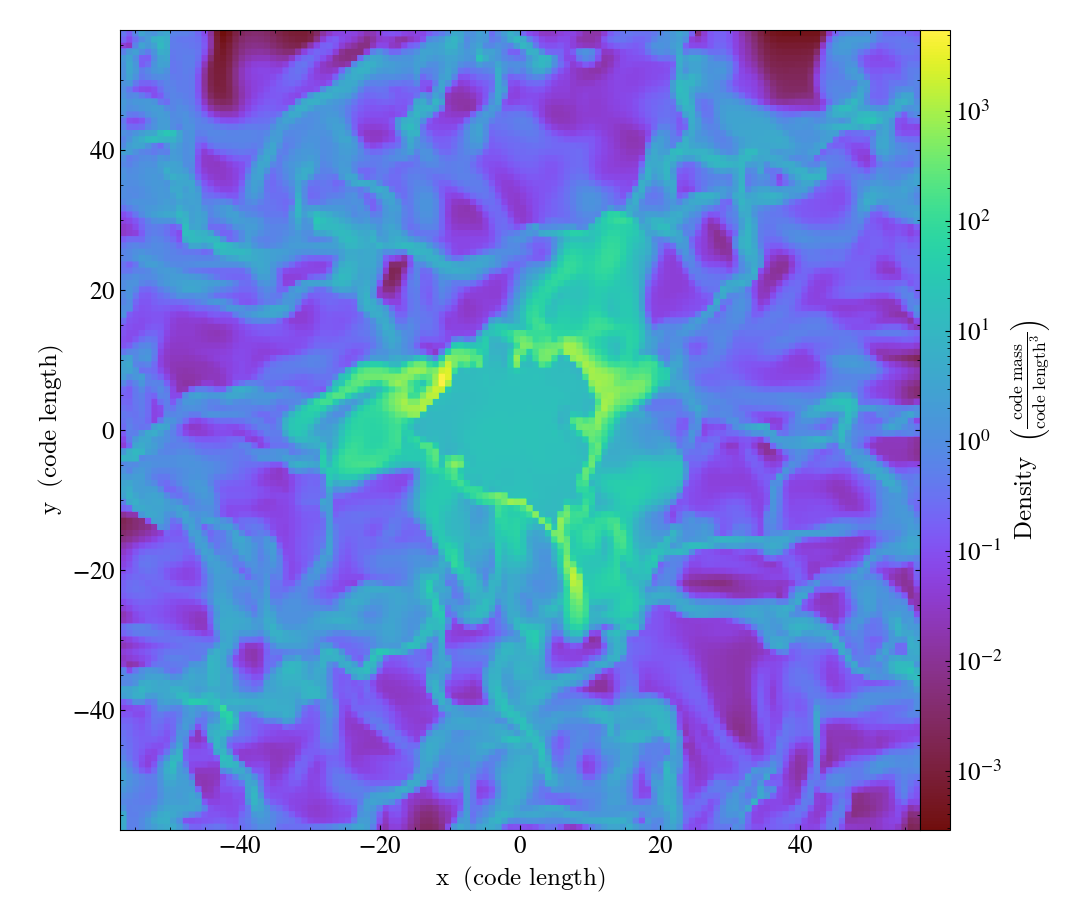

In [45]:
yt.SlicePlot(ds,'z','density')